# SEN2VENμS

## [SEN2VENµS, a Dataset for the Training of Sentinel-2 Super-Resolution Algorithms](https://www.mdpi.com/2306-5729/7/7/96)
- This is the paper which discusses the dataset
- Sentinel-2 has the current highest spatial resolution of any free and open-data policy Earth observation mission in the optical domain. Sentinel-2 has 10m imagery with 5 day revisit frequency.
- A resolution of 10m can be limiting for some applications though, which is why there's interest in Single Image Super-Resolution (SISR) which claims to offer a significant increase in resolution without any additional input other than the Sentinel-2 10m image itself
- Interesting extracts from the paper intro:
    - "Remote sensing satellites often offer several spectral bands with different resolutions for a given sensor. For instance, Sentinel-2 has 10 m resolution blue, green, red and wide near infrared channels but three red edge bands and a narrow infrared channel at 20 m resolution and atmospheric correction bands at 60 m resolution. In the literature, there are several model-based methods aimed at sharpening all bands to the highest sensor resolution, as well as deep-learning-based methods"
    - SISR: "Single Image Super-Resolution is the task of obtaining a higher resolution version of a single image, using no other inputs that the image itself. In the context of remote sensing satellite imagery, higher resolution means that not only the same area on the ground is covered by a higher number of smaller pixels, which can be achieved by means of traditional spatial re-sampling techniques, but also that the super-resolved image exhibits faithful higher spatial frequency content with respect to the original image."
    - "This paper does not propose any new SIRS method, nor is it benchmarking existing SISR methods. Instead, the aim of this paper is to describe the source data, generation process and content of SEN2VENµS, an open dataset for the super-resolution of Sentinel-2 images built by leveraging simultaneous acquisitions with the VENµS satellite (see Section 2.1 for a detailed description of those satellite missions). This dataset has been made publicly available in hopes to laying the groundwork for future work in the remote sensing community for fair benchmarking, comparison and further research on SISR methods, using data that are representative of remote sensing usages. The dataset is composed of 10 m and 20 m cloud-free surface reflectance patches from Sentinel-2, with their reference spatially registered surface reflectance patches at 5 m resolution acquired on the same day and within 30 min at most by the VENµS satellite. It covers 29 locations with a total of 132,955 patches of 256 × 256 pixels at 5 m resolution. It can be used for the training and comparison of super-resolution algorithms to bring spatial resolution of eight of the Sentinel-2 bands up to 5 m."

## [SEN2VENµS, a dataset for the training of Sentinel-2 super-resolution algorithms](https://zenodo.org/records/6514159)
- Open dataset for training super-resolution models on Sentinel-2 images.
- Sentinel-2 images are 10m and 20m resolution cloud-free surface reflectance patches from Sentinel-2
- VENµS images are 5m resolution images acquired on the same day by the VENµS satellite
- The dataset has Sentinel-2 and VENµS pairs - essentially a lower-res image (Sentinel-2) paired with a higher-res image (VENµS). Specifically we are looking to train a super-resolution model to bring the spatial resolution of 8 of the Sentinel-2 bands from 10m down to 5m.
- The dataset is comprised of separate sub-datasets - one for each site. Each site has a specified number of patches, specified number of pairs, and the VENµS viewing zenith angle.
- Patches are encoded as ready-to-use Pytorch tensors. Bands are separated into two groups (10m and 20m Sentinel-2 bands), leading to 4 separate tensor files (2 groups of bands x source and target resolution).
- Tensor shape is $[n, c, w, h]$ where $n$ is the number of patches, $c = 4$ is the number of bands, and $w \times h$ is the patch size (width x height). They are encoded as 16 bit signed ints to save space, but should be converted back to floating point surface reflectance by dividing every value by 10,000 upon reading

Surface reflectance - % of solar radiation that is reflected from Earth's surface

In [1]:
from super_resolution.src.sen2venus_dataset import S2VSite

import matplotlib.pyplot as plt
import math
import numpy as np
import torch

In [2]:
site = S2VSite(site_name = "FGMANAUS", bands="rgbnir", download_dir="../data/", device="cpu")
print(f"{len(site)} patches")

516 patches


Sent2 RGB, Sent2 NIR, Venus RGB, Venus NIR


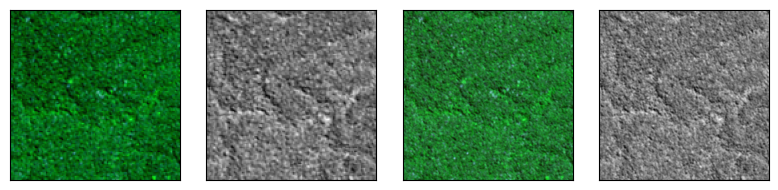

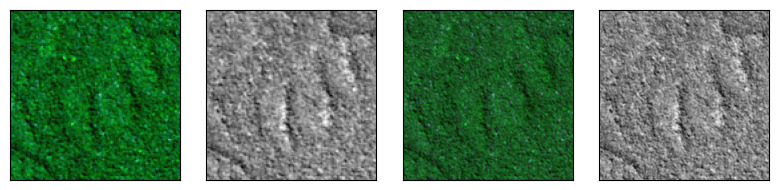

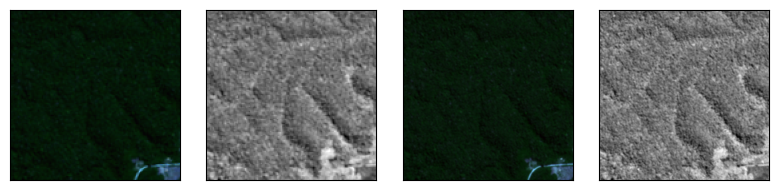

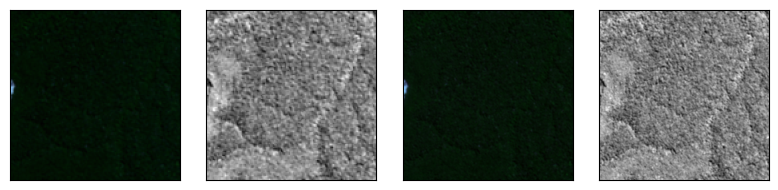

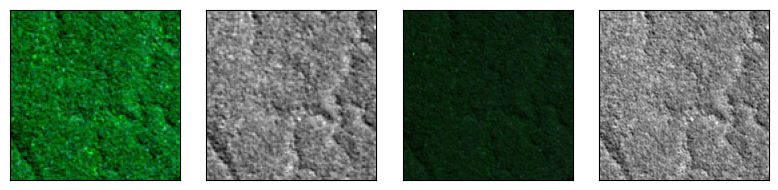

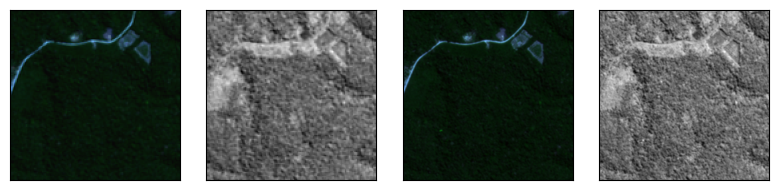

In [ ]:
def plot_gallery(images, titles=None, xscale=1.5, yscale=1.5, nrow=1, output=None):
    ncol = math.ceil(len(images) / nrow)
    
    plt.figure(figsize=(xscale * ncol, yscale * nrow))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        if i < len(images):
            if len(images[i].shape) == 2:
                plt.imshow(images[i], cmap="gray")
            else:
                plt.imshow(images[i])
            if titles is not None:
                # use size and y to adjust font size and position of title
                plt.title(titles[i], size=10, y=1)
        plt.xticks(())
        plt.yticks(())

    plt.tight_layout()

    if output is not None:
        plt.savefig(output)
    plt.show()

# We need to normalize the surface reflectance values so that they are in the range [0, 1]
def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

print("Sent2 RGB, Sent2 NIR, Venus RGB, Venus NIR")
for i in range(0, 20):
    input_tensor, target_tensor = site[i]
    # For RGB images, imshow wants the dimensions to be (width, height, channels)
    # The first three channels are RGB, the last is NIR
    input_rgb = normalize_tensor(input_tensor[:3].permute(1, 2, 0))
    input_nir = input_tensor[3]
    target_rgb = normalize_tensor(target_tensor[:3].permute(1, 2, 0))
    target_nir = target_tensor[3]
    plot_gallery([input_rgb, input_nir, target_rgb, target_nir], xscale=2, yscale=2)